In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from tensorflow.python.client import device_lib

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, BatchNormalization, Convolution2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
tf.__version__

'2.1.0'

In [5]:
keras.__version__

'2.2.4-tf'

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.shape

(42000, 785)

In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test.shape

(28000, 784)

In [10]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
x_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
x_test = test.values.astype('float32')

In [12]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
x_train = x_train.reshape(x_train.shape[0], 28, 28)

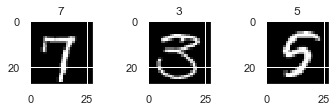

In [14]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [15]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

In [16]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [17]:
x_train.shape

(42000, 28, 28, 1)

In [18]:
x_test.shape

(28000, 28, 28, 1)

In [19]:
mean_px = x_train.mean().astype('float32')
std_px = x_train.std().astype('float32')

def standardize(x):
    return (x-mean_px)/std_px

In [20]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

c:\users\wonhee\anaconda3\envs\tensorgpu211\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


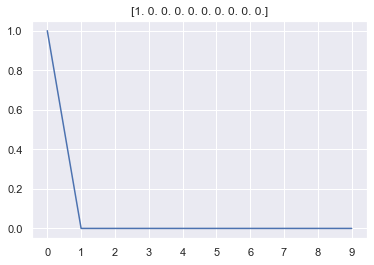

In [23]:
plt.title(y_train[200])
plt.plot(y_train[200])
plt.xticks(range(10));
plt.show()

In [21]:
seed = 43
np.random.seed(seed)

In [22]:
model = Sequential()
model.add(Lambda(standardize, input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

print('input layer', model.input_shape)
print('output_layer', model.output_shape)

input layer (None, 28, 28, 1)
output_layer (None, 10)


In [23]:
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
gen = ImageDataGenerator()

In [25]:
X = x_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state = 42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [26]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=4, validation_data = val_batches, validation_steps = val_batches.n)

Epoch 1/4
  219/37800 [..............................] - ETA: 26:47 - loss: 0.6276 - accuracy: 0.8047

KeyboardInterrupt: 

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Text(0, 0.5, 'Losses')

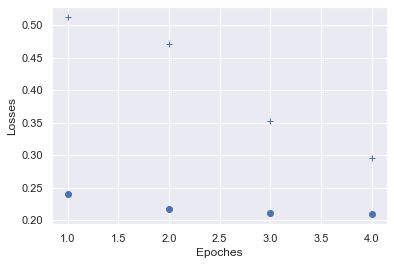

In [35]:
losses = history_dict['loss']
val_losses = history_dict['val_loss']
epoches = range(1, len(val_losses)+1)

plt.plot(epoches, losses, 'bo')
plt.plot(epoches, val_losses, 'b+')
plt.xlabel('Epoches')
plt.ylabel('Losses')

Text(0, 0.5, 'Accuracy')

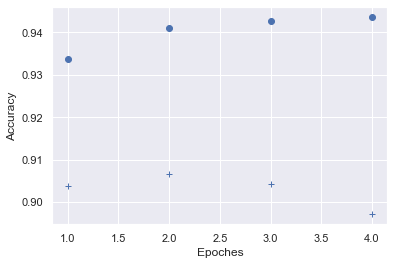

In [36]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

plt.plot(epoches, accuracy, 'bo')
plt.plot(epoches, val_accuracy, 'b+')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')

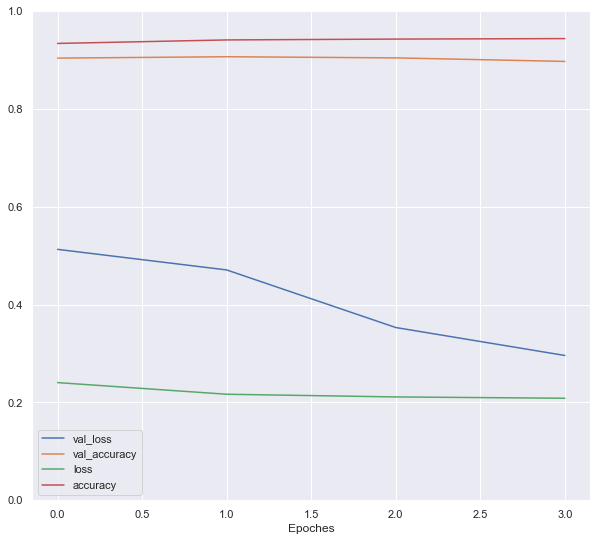

In [39]:
pd.DataFrame(history.history).plot(figsize=(10, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoches')
plt.show()

In [40]:
def fully_connected_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28, 28, 1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='Adam'(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [43]:
fc = fully_connected_model()

In [45]:
history = fc.fit_generator(generator = batches, steps_per_epoch = batches.n, epochs=2, validation_data = val_batches, validation_steps = val_batches.n)

Epoch 1/2
37800/37800 [==============================] - 224s 6ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.2278 - val_accuracy: 0.9769
Epoch 2/2
37800/37800 [==============================] - 226s 6ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.2391 - val_accuracy: 0.9824


In [46]:
history2_dict = history.history
history2_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

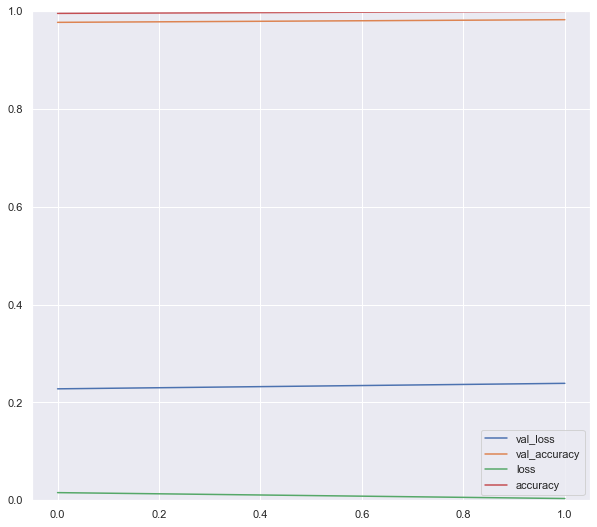

In [47]:
pd.DataFrame(history2_dict).plot(figsize=(10, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [48]:
fc.save('Fully Connected Layer.h5')

In [26]:
def cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28, 1)),
        Convolution2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
        Convolution2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    optimizer=RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [30]:
cnn_model = cnn_model()

In [31]:
get = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X, y, batch_size=256)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=10, callbacks=[learning_rate_reduction])

Epoch 1/10
42000/42000 [==============================] - 1877s 45ms/step - loss: 0.2157 - accuracy: 0.9390
Epoch 2/10
    2/42000 [..............................] - ETA: 1:08:03 - loss: 0.2366 - accuracy: 0.9316

c:\users\wonhee\anaconda3\envs\tensorgpu211\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


42000/42000 [==============================] - 1560s 37ms/step - loss: 0.1965 - accuracy: 0.9445
Epoch 3/10
42000/42000 [==============================] - 1501s 36ms/step - loss: 0.1922 - accuracy: 0.9457
Epoch 4/10
42000/42000 [==============================] - 1450s 35ms/step - loss: 0.1898 - accuracy: 0.9464
Epoch 5/10
42000/42000 [==============================] - 1485s 35ms/step - loss: 0.1884 - accuracy: 0.9467
Epoch 6/10
42000/42000 [==============================] - 1513s 36ms/step - loss: 0.1873 - accuracy: 0.9471
Epoch 7/10
42000/42000 [==============================] - 1529s 36ms/step - loss: 0.1868 - accuracy: 0.9474
Epoch 8/10
42000/42000 [==============================] - 1523s 36ms/step - loss: 0.1862 - accuracy: 0.9475
Epoch 9/10
42000/42000 [==============================] - 1535s 37ms/step - loss: 0.1857 - accuracy: 0.9477
Epoch 10/10
42000/42000 [==============================] - 1524s 36ms/step - loss: 0.1853 - accuracy: 0.9478


In [32]:
cnn_model.save('CNN model trained on all training set.h5')